# Nuclear Data

PyNE provides a top-level interface for a variety of basic nuclear data needs. This aims to provide quick access to very high fidelity data. Values are taken from the `nuc_data.h5` library.  The basic suite of data comes from public sources.  However if you have access to proprietary or export-controlled data, such as CINDER cross sections, then PyNE will attempt to provide an interface to this as well.

All functionality may be found in the data module:

In [2]:
from pyne import data

/home/tyler/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


The usual suspects follow.

## Atomic Mass [amu]
Finds the atomic mass of a nuclide

In [3]:
data.atomic_mass('U235')

235.043930131

## Natural Abundance Ratios
Finds the natural abundance of a nuclide

In [4]:
data.natural_abund('U235')

0.007204

In [5]:
data.natural_abund('Pu-239')

0.0

## Half Lives (s) & Decay Constants (1/s)
Finds the amount of time for half of the radionuclide to decay (half life). Decay constant is another measure of the rate of radioactive decay.

In [6]:
data.half_life('U-238')

1.409993568e+17

In [7]:
data.decay_const('U-238')

4.915959875924379e-18

## Decay Children

In [8]:
data.decay_children('Rb86')

set([360860000, 380860000])

In [9]:
from pyne import nucname
print("Rb86 decayse to two isotopes,", "\n")
print("The first daughter is", nucname.name(360860000), "\n")
print("The second daughter is", nucname.name(380860000), "\n")

Rb86 decayse to two isotopes, 

The first daughter is Kr86 

The second daughter is Sr86 



In [10]:
print("It decays to ",nucname.name(360860000), " with a branch ratio of ", data.branch_ratio('Rb86', 360860000))

It decays to  Kr86  with a branch ratio of  5.2e-05


## Neutron Scattering Lengths [cm]
Finds the bound scattering length; the generic value is computed from the coherent and incoherent scattering data:

$$b = \sqrt{\left| b_{\mbox{coh}} \right|^2 + \left| b_{\mbox{inc}} \right|^2}$$

In [11]:
data.b('H1')

2.554930849083787e-12

In [12]:
data.b_coherent('H1')

(-3.7406e-13+0j)

In [13]:
data.b_incoherent('H1')

(2.5274000000000003e-12+0j)

## Half-life Plot

Text(0,0.5,'Half-life [s]')

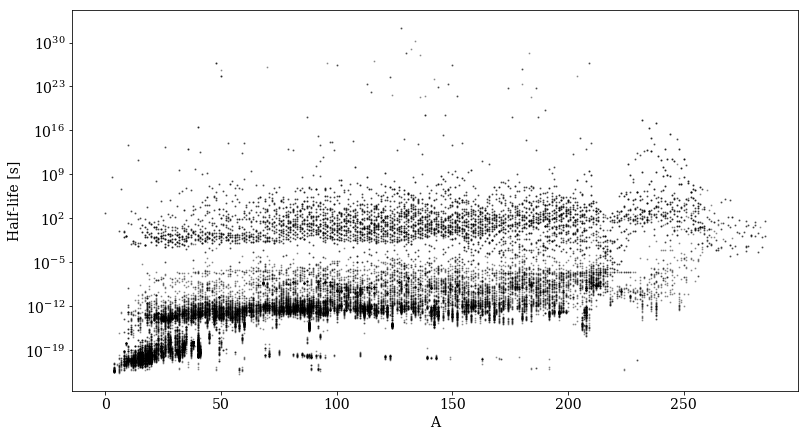

In [14]:
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='serif', size=14)
import matplotlib.pyplot as plt
from pyne import nucname, nuc_data

import tables as tb
f = tb.open_file(nuc_data)
# get a map between nucleon numbers and half-lives

#anums = map(nucname.anum, f.root.decay.level_list[:]['nuc_id'])
#anums = map(nucname.anum, data.half_life_map.keys())
NuclearName= list(map(lambda x:int(x),f.root.decay.level_list[:]['nuc_id']))
anums = map(nucname.anum, NuclearName)

fig = plt.figure(figsize=(13,7))
plt.semilogy(list(anums),  f.root.decay.level_list[:]['half_life'], 'ko', ms=1, alpha=0.3)
plt.xlabel('A')
plt.ylabel('Half-life [s]')

#ENSDF decay data
In addition to the basic ENSDF data interface shown above, there is an extended interface that provides access to a large portion of the decay data in the ENSDF dataset. For example lets look at Cs-137:

In [15]:
# we can look up most decay data by parent or by decay energy
# returns a list of gamma ray level pairs from ENSDF decay data from a given parent's state id.
decay_pairs = data.gamma_from_to_byparent(551370000)
print("The decay pairs are ", decay_pairs, ",\n")

# this resturns a list of gamma ray energies given a parent
energies = data.gamma_energy(551370000)

print("and they have these energies (paired with errors):", (energies), ".\n")

The decay pairs are  [(561370001, 561370000), (561370002, 561370000)] ,

and they have these energies (paired with errors): [(283.5, 0.1), (661.657, 0.003)] .



In [17]:
# these are relative gamma intensities
intensities = data.gamma_photon_intensity(551370000)

# This converts the relative intensities to decays per 100 decays of the parent
photonbr, photonbr_error = data.decay_photon_branch_ratio(551370000,561370000)
final_intensities = []
#print 
for item in intensities:
    # compute the intensities by multiplying the branch ratio and the relative intensity; ignore the errors 
    final_intensities.append(photonbr*item[0])

print(nucname.name(551370000), "gamma decays to", nucname.name(561370000), "with intensities", final_intensities, "\n")
     
# Alpha intensities a bit trickier because we need to get the reaction
from pyne import rxname
# This is intensity per 100 alpha decays with no errors 
a_intensities = data.alpha_intensity(922290000)

# Find the alpha branch intensity
a_br = data.branch_ratio(922290000,rxname.child(922290000,'a')) #alpha decay


# Calculate the intensities of each alpha per 100 decays of the parent
a_final_intensities = []
for item in a_intensities:
    a_final_intensities.append(a_br*item)
    
print(nucname.name(922290000), "decays to", nucname.name(rxname.child(922290000,'a')),"with intensities", a_final_intensities, "\n")

Cs137 gamma decays to Ba137 with intensities [0.00058, 85.1] 

U229 decays to Th226 with intensities [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 



## Another possible use is the search for candidate gamma rays

In [18]:
# The default range is +- 1 keV, which returns a lot of stuff
possible_parents = data.gamma_parent(661.657)
print("number of possible parents of 661.657 +- 1keV decay is", len(possible_parents), "\n")

# Or, return gamma ray level pairs based on gamma ray energy (another way to do it)
from_to = data.gamma_from_to_byen(661.657)

# Or, a list of gamma ray  intensities from a given gamman ray energy (another way to do it)
intensity_list = data.gamma_photon_intensity_byen(661.657)


number of possible parents of 661.657 +- 1keV decay is 894 



In [19]:
# we can downselect from this
import numpy as np
from pyne import nucname
hls = []
final_ints = []
parents = []

for i, item in enumerate(possible_parents):
    
    # Temporary fix for bug
    if from_to[i][0] < 0:
        continue
        
    # gammas that don't have from-to pairs get lost here
    phbr = data.decay_photon_branch_ratio(item,nucname.groundstate(from_to[i][0]))
    
    # Select non-zero branch ratios, intensities over 5% of all decays, and half lives over 10 days
    if phbr[0] > 0.0 and intensity_list[i][0]*phbr[0] > 5.0:
        if nucname.groundstate(from_to[i][0]) != item and data.half_life(item,False) > 60.*60.*24.*10.:
            parents.append(item)
            hls.append(data.half_life(item,False))
            final_ints.append(intensity_list[i][0]*phbr[0])

# now we have a managably short list
for i, item in enumerate(parents):
    # Temporary fix for bug
    if item < 0:
        continue
    print("possible candidate: {0}".format(nucname.name(item)))
    print("half life: {0} s/ {1} days/ {2} years".format(hls[i],hls[i]/(60.*60.*24.),hls[i]/(60.*60.*24.*365.25)))
    print("intensity: {0} %".format(final_ints[i]))
    print("################################################################")
    

possible candidate: Ag110M
half life: 21585312.0 s/ 249.83 days/ 0.6839972621492129 years
intensity: 95.61123 %
################################################################
possible candidate: Cs137
half life: 949252608.0 s/ 10986.72 days/ 30.08 years
intensity: 85.1 %
################################################################
possible candidate: I126
half life: 1117152.0 s/ 12.93 days/ 0.03540041067761807 years
intensity: 32.884800000000006 %
################################################################
possible candidate: Sb126
half life: 1067040.0 s/ 12.35 days/ 0.03381245722108145 years
intensity: 99.6 %
################################################################
